## Imports and info

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Dec 6, 2024

@author: Jamiree Harrison
         https://github.com/Jamiree
         jamiree@ucsb.edu

Purpose of script: 
1. Simulates advection diffusion equation data with continuously varying parameter. 
2. Produces advec-diff equation model parameters that fit the simulated data. 

"""

# Imports
import numpy as np
from numpy import linalg as LA
from scipy.linalg import toeplitz
import math
import matplotlib.pyplot as plt
import random
import ruptures as rpt
import string
from itertools import product
from scipy.signal import savgol_filter
from mpl_toolkits import mplot3d
from random import gauss
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import os

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Backend Functions

In [2]:
############################################################ 

''' Uses binary segmentation to detect when a signal switches
    
    Documentation: 
    https://centre-borelli.github.io/ruptures-docs/user-guide/detection/binseg/

'''
def bkpt_binseg(signal, model, sigma): 
    
    n = len(signal)
    
    # Point Detection:
    # here we choose the Least-squares estimate for changes in autoregressive (ar) coefficients
    algo = rpt.Binseg(model=model).fit(signal)
    
    # manually select how many breakpoints to select
    if type(sigma) == str:
        sigma = int(sigma)
        my_bkps = algo.predict(n_bkps=sigma)
        
        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()
        
    else:
    
        ## if we want to treat the number of change points as unknown, use
        ## one of the following (note: sigma is the standard deviation of the noise. ) : 

        ## specify a penalty using the pen parameter
        # sigma = 0.1
        # dim = 1
        # my_bkps = algo.predict(pen=np.log(n) * sigma**2)

        ## specify a threshold on the residual norm using epsilon
        ## note that sigma needs to be small for non-noisy data
        my_bkps = algo.predict(epsilon = n * sigma**2)

        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()

    return my_bkps


############################################################ 

''' Detects the times that a signal "switches"

inputs:  data                            | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
         t                               | array of size (num_time_pts, 1)
             - time vector
             
         switch_gap                      | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         ls_model                           | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         \\sigma   (type determined)     | float 
                                 | (if the number of switches is
                                 | to be determined by algorithm)
            - standard deviation of the noise in the data
         \\sigma   (type determined)     | str 
                                | (if the number of switches is
                                | to be input by the user)
            - standard deviation of the noise in the data
                
outputs: t_switch_index         | array of size (num_switches, 0) 
         num_switches           | integer
         num_time_intervals     | integer
         time_of_switch         | array of size (num_switches, 0) 
'''
def switch_time_detect(data, t, switch_gap, ls_model, sigma):
    
    num_time_pts, num_states = np.shape(data)
    
    true_t_switch_index = np.array([], dtype=int)
    
    # iterate over all states of system
    for j in range(num_states):
        
        # detects switch time using binary segmentation 
        t_switch_index = bkpt_binseg(data[:,j], ls_model, sigma)

        # the following code removes switch indices that are too close for each state
        result = [t_switch_index[0]]
        for i in range(1, len(t_switch_index)):
            # makes it so that consecutive switches are not too close
            if t_switch_index[i] > t_switch_index[i - 1] + switch_gap:
                # Remove the current indexed entry
                result = np.append(result, t_switch_index[i])

        # makes it so that the last time point cannot be a switch time
        if result[-1] == len(t):
            result = np.delete(result, -1)
            
        
        # indices of t where state switching occurs in the j-th state
        t_switch_index = result 
        
        # print('switches = ',t_switch_index)
        
        # only takes switches not already detected from previous states
        for entry in t_switch_index:
            if entry not in true_t_switch_index:
                true_t_switch_index = np.append(true_t_switch_index, entry)
        true_t_switch_index = np.sort(true_t_switch_index)

        # print('time indices of switches: ', true_t_switch_index)
        
    # checks if there are no switches
    if len(true_t_switch_index) == 0:

        num_switches = 0
        time_of_switch = np.zeros((num_switches,))
        num_time_intervals = num_switches + 1
        print('no switches detected in signal given chosen parameters')
        
        return true_t_switch_index, num_switches, num_time_intervals, time_of_switch
            
    else:
        result = [true_t_switch_index[0]]
        for i in range(1, len(true_t_switch_index)):
            # makes it so that consecutive switches are not too close
            if true_t_switch_index[i] > true_t_switch_index[i - 1] + switch_gap:
                # Remove the current indexed entry
                result = np.append(result, true_t_switch_index[i])
                
        # makes it so that the last time point cannot be a switch time            
        if result[-1] == len(t):
            result = np.delete(result, -1)

        true_t_switch_index = result
               
    num_switches = len(true_t_switch_index)
    
    if isinstance(sigma, str) and int(sigma) != num_switches:
        print('expected switch number not equal to detected number of switches')


    # gets times of switches
    time_of_switch = np.zeros((num_switches,))
    for i in range(num_switches):
        time_of_switch[i] = t[true_t_switch_index[i]]

    print('times_of_switches = ', time_of_switch)

    
    # plt.figure()
    # plt.plot(t, data[:,num_states//2], 'g', label='x(t)')
    # plt.plot(t[true_t_switch_index], data[true_t_switch_index, num_states//2], 'ro')
    # plt.xlabel('time')
    # plt.ylabel('cross section of u(t,x) for some x')
    # plt.title('switch times found')
    # plt.savefig(os.path.join(os.getcwd(), 'switch times.svg'), format='svg')
    # plt.show()
        
    num_time_intervals = num_switches + 1
    
#     print('num_switches =', num_switches)
#     print('num_time_intervals =', num_time_intervals)
    
    return true_t_switch_index, num_switches, num_time_intervals, time_of_switch

    
############################################################ 

''' Breaks data up into sections based on the 
    times of the switches

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         t                      | array of size (num_time_pts, 1)
             - time vector
        
         num_switches           | integer
        
         t_switch_index         | array of size (num_switches, 0) 
                     
outputs: data_intervals_dict    | dictionary of data over time intervals
            - example: data_intervals_dict['data_t0']
                       gives the data over the first time interval
                       
         time_intervals_dict    | dictionary of time intervals
            - example: time_intervals_dict['t0']
                       gives the first time interval
'''
def data_segementation(data, t, num_switches, t_switch_index):
    
    # instantiate dictionary of data over the time intervals
    data_intervals_dict = {}

    # instantiate dictionary of the time intervals
    time_intervals_dict = {}

    # used to iterate through every time point
    temp_index = 0  

    # iterates through time up to the last switch time
    for i in range(num_switches):
        
        key = f"t{i}"
        
        # data over the i-th time interval
        data_intervals_dict[key] = data[temp_index:t_switch_index[i] , :]

        # the i-th time interval
        time_intervals_dict[key] = t[temp_index:t_switch_index[i]]

        # updtate the index of the current time point
        temp_index = t_switch_index[i]

    # data over the last time interval
    key = f"t{num_switches}"
    data_intervals_dict[key] = data[temp_index: , :]

    # last time interval
    time_intervals_dict[key] = t[temp_index:]
    
    return data_intervals_dict, time_intervals_dict

############################################################ 

''' Fits the params of the model over each time interval

inputs:  data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
        
         dt                     | float
             - sampling time, i.e. difference between time points
             
         params_init            | array of size (num_model_params, )
         bounds                 | see documentation for scipy optimize
          https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
         
         num_time_intervals.    | float
                     
outputs: params_dict            | dictionary of parameter values over 
                                | each time interval

         param_matrix           | array of size (num_model_params, num_time_intervals)
         param_time             | dictionary of parameter values for each point in time

'''
def fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, bounds, 
               num_time_intervals, num_static_params):
    
    num_model_params = len(params_init)
    
    # matrix of params
    param_matrix = np.zeros((num_model_params, num_time_intervals))

    # dictionary of params
    params_dict = {}

    for i in range(num_time_intervals):

        # Minimize the objective function over each time domain

        key = f"t{i}"
        
        result = minimize(objective, 
                         params_init, 
                         args=(data_intervals_dict[key], 
                               dt, time_intervals_dict[key]), 
                         method='Nelder-Mead', 
                         bounds = bounds)
        
        params_approx = result.x

        params_dict[key] = params_approx
        param_matrix[:,i] = params_approx

        # Print the estimated parameters
        # print("Estimated parameters for the " + str(i+1)  +"th time interval:")

        # Sets initial parameter value guesses for next time interval
        # Note that we use the results from the first time domain fit as our new
        # initial guesses
        params_init = result.x
        
        if i == 0: 
            # first set of params found over first time interval
            first_params = result.x
            
            num_vary_params = num_model_params - num_static_params
            
            # if no bounds are selected for the params, then make it so that
            # the time-varying params are able to vary, while the static
            # params must stay the same.
            if bounds == None:
                bounds = []
                # set bounds for params in the form of : (lower, upper)
                for j in range(num_vary_params):
                    bounds.append((-np.inf , np.inf)) 
                
                # makes it so that the static params do not change
                for j in range(num_static_params):
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                    
            else: 
                
                # if bounds are selected for the params, then make it so that
                # the time-varying params are able to vary within the pre-set bounds
                # while the static params must stay the same.
                bounds = bounds[:num_vary_params]     # keeps initialized bounds
                for j in range(num_static_params):
                    # makes it so that the static params do not change
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                
            print('bounds=',bounds)

    # dictionary containing arrays of each parameter at each time point
    param_time = {}

    for k in range(num_model_params):

        # initialize array
        param_time[f"p{k}"] = []
        for i in range(num_time_intervals):

            # iterates through time intervals and stitches together the parameter arrays
            param_time[f"p{k}"] = np.append(param_time[f"p{k}"] , 
                                   param_matrix[k,i]*np.ones(len(time_intervals_dict[f't{i}'])))
        
    return params_dict, param_matrix, param_time

############################################################ 

''' Generate approx trajectory using estimated params

inputs:  params_dict            | dictionary of parameters for each time interval

         data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
         
         num_time_intervals.    | float
                     
outputs: traj_dict              | dictionary of trajectories over each time interval
                               
'''
def predicted_trajectories(params_dict, data_intervals_dict, time_intervals_dict, num_time_intervals):

    traj_dict = {}

    for i in range(num_time_intervals):

        key= f"t{i}"
   


        tspan = time_intervals_dict[key]

        y0 = data_intervals_dict[key][0,:]

        traj_dict[key] = odeint(pend, y0, tspan, 
                                          args =  tuple(params_dict[key]))
        
        # puts all trajectories into one array
        if i==0:
            traj = traj_dict[key]
        else:
            traj = np.append(traj , traj_dict[key], axis = 0)

            
    return traj_dict, traj


############################################################ 


''' Computs the error of the found trajectory

inputs:  data_intervals_dict    | dictionary of semented data

         traj_dict              | dictionary of trajectories over each time interval
         
         num_time_intervals     | integer
                     
outputs: err_dict               | dictionary of approximation error over each time interval
    
         err_arry               | array of size (num_time_pts, num_states)

         total_err              | float 
             - norm of error array

'''
def traj_err(data_intervals_dict, traj_dict, num_time_intervals):
    
    err_dict = {}
    
    for i in range(num_time_intervals):

        key = f"t{i}"
        
        err_dict[key] = (traj_dict[key] - data_intervals_dict[key])
        
        # puts all errors into one array
        if i==0:
            err_array = err_dict[key]
        else:
            err_array = np.append(err_array , err_dict[key], axis=0)
                            
    total_err = LA.norm((err_array),2)/len(err_array)

    return err_dict, err_array, total_err

############################################################ 

''' continuous piecewise time-varying model identification

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         switch_gap             | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         model                   | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         sigma                   | float
            - standard deviation of the noise in the data
                
outputs: result                  | dictionary of identified model results
            - print(result.keys()) 
            - run the above line of code for outputs
'''
def cont_pw_tv_model_ID(data, t, switch_gap, ls_model, sigma, params_init, bounds, num_static_params):
    
    num_time_pts, num_states = np.shape(data)

    # time step
    dt = t[1] - t[0]

    ## Switch time detection

    # define data signal which contains switches
    switch_signal = data

    t_switch_index, num_switches, num_time_intervals, time_of_switch = switch_time_detect(switch_signal, 
                                                                                          t,
                                                                                          switch_gap, 
                                                                                          ls_model, 
                                                                                          sigma)


    # breaks data up into sections based on the 
    # times of the switches
    data_intervals_dict, time_intervals_dict = data_segementation(data, t, num_switches, t_switch_index)

    ## Estimate the parameters of the genetic mybrid promoter model using SciPy optimization
    ## over each time interval

    params_dict, param_matrix, param_time = fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, 
                                           model_param_bounds, num_time_intervals, num_static_params)

    # generate approx trajectory based on estimated params

    traj_dict, traj = predicted_trajectories(params_dict, 
                                       data_intervals_dict, 
                                       time_intervals_dict, 
                                       num_time_intervals)
    
    err_dict, err_array, total_err = traj_err(data_intervals_dict, traj_dict, num_time_intervals)
        
    # results form fitting params to the model
    result = {'params_dict': params_dict, 
               'param_matrix':param_matrix, 
               'traj_dict':traj_dict, 
               'traj':traj,
               'data_intervals_dict':data_intervals_dict, 
               'time_intervals_dict':time_intervals_dict, 
               't_switch_index':t_switch_index, 
               'num_switches':num_switches, 
               'num_time_intervals':num_time_intervals,
               'time_of_switch':time_of_switch,
               'err_dict':err_dict,
               'err_array':err_array,
               'total_err':total_err,
               'param_time':param_time}
    
    return result
    

## USER INPUT: Must define parametrized system and objective function

In [3]:
''' Dynamics for simulation
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         param_1                 | float
         param_2
         .
         .
         .
         param_n
                
outputs: dydt                    | array of size (num_states, ) 
'''
def pend(y, ti, a, d):
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))

    # Initialize matrices
    row_xx = np.zeros(n)
    row_xx[0] = -2
    row_xx[1] = 1
    col_xx = row_xx

    row_x = np.zeros(n)
    row_x[0] = -1
    col_x = np.zeros(n)
    col_x[0] = -1
    col_x[1] = 1

    # Construct Toeplitz matrix
    T_x = toeplitz(col_x, row_x)
    T_xx = toeplitz(col_xx, row_xx)

    # Compute scaled matrices
    A_x = a * T_x / (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x

    dydt = A @ y + bc
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

########################################################################################

''' Dynamics for objective function
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         params                  | array of size (num_params, )
             - must be coordinated with the params in pend
                
outputs: dydt                    | array of size (num_states, ) 
'''
# dynamics for objective function
def obj_dynamics(y, ti, params):
    
    a, d = params
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))

    # Initialize matrices
    row_xx = np.zeros(n)
    row_xx[0] = -2
    row_xx[1] = 1
    col_xx = row_xx

    row_x = np.zeros(n)
    row_x[0] = -1
    col_x = np.zeros(n)
    col_x[0] = -1
    col_x[1] = 1

    # Construct Toeplitz matrix
    T_x = toeplitz(col_x, row_x)
    T_xx = toeplitz(col_xx, row_xx)
    
    # Compute scaled matrices
    A_x = a * T_x/ (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x
    
    dydt = A @ y + bc
    

    # Return the rates of change of the concentrations as a NumPy array
    return np.array([dydt])

############################################################ 

''' Objective function to minimize
inputs:  params                  | array of size (num_params, )
             - must be coordinated with the params in pend
         
         data                    | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         dt                      | float
             - sampling time, i.e. difference between time points
         
         t                       | array of size (num_time_pts, )
             - time vector
                
outputs: err                     | float
'''
def objective(params, data, dt, t):
    
    m,n = np.shape(data)
    
    # initialize array for predicted data.
    # we leave off the initial condition because that is given to us
    x_pred = np.zeros((m-1,n))
    x_data = data[1:,:]
    
    # use euler's method to solve ODE with set of params
    for i in range(len(data)-1):
        x0 = data[i,:]
        x_pred[i,:] = x0 + obj_dynamics(x0, t[i], params)*dt
    
    # distance between the predicted data and the real data
    err = LA.norm((x_data - x_pred),2)
    
    return err

## Simulate advec-diffusion with continuously varying parameter

In [4]:
ti = 0     # start time

tf = 1    # end time



n_t =  100   # number of time points
n_x =  100    # number of space points

t = np.linspace(ti, tf, n_t)

dt = t[1] - t[0]

# space step size
dx =  np.pi / n_x 

# x grid
x = np.linspace(-np.pi/4, np.pi, n_x)

T, X = np.meshgrid(t, x)

## create initial condition 
## u(x) = x      if x <= pi/2
##      = pi - x if x >= pi/2
# u0 = np.zeros((n,))
# for i in range(n):
#     if x[i] <= np.pi / 2:
#         u0[i] = x[i]
#     else:
#         u0[i] = np.pi - x[i]

# u0 = np.ones((n_x,))

# create initial condition 
u0 = np.zeros((n_x,))
for i in range(n_x):
    if x[i] >0 :
        u0[i] = np.sin(3*x[i])


def param1(ti):
    # p = 0.01*ti**0.5
    p= 1.*np.sin(-1.+ 3.*ti)
    return p

def param2(ti):
    # p = .01*(ti)**0.2
    
    if isinstance(ti, np.ndarray):
        p= .01*np.ones((len(ti),))
    else: 
        p=.01
    return p


n=len(u0)

# Initialize matrices
row_xx = np.zeros(n)
row_xx[0] = -2
row_xx[1] = 1
col_xx = row_xx

row_x = np.zeros(n)
row_x[0] = -1
col_x = np.zeros(n)
col_x[0] = -1
col_x[1] = 1

# Construct Toeplitz matrix
T_x = toeplitz(col_x, row_x)
T_xx = toeplitz(col_xx, row_xx)

def pend2(y, ti, T_x, T_xx):
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))
    # bc[0] = 1
    
    # define parameters
    a = param1(ti)
    d = param2(ti)
    
    # Compute scaled matrices
    A_x = a * T_x / (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x 
    
    dydt = A @ y + bc
    
    # print(A)
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt


# true solution over first time interval
u_true = odeint(pend2, u0, t, args = (T_x, T_xx))


## plot of u true solution

Text(0.5, 0.92, 'true solution for u(t,x)')

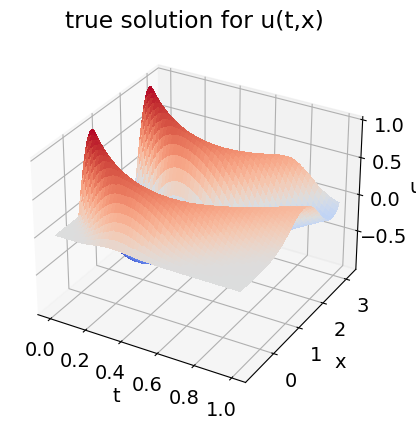

In [5]:

fig = plt.figure()
ax = fig.add_subplot( projection='3d')
surf = ax.plot_surface(T, X, u_true.T, cmap = 'coolwarm',
                linewidth=0, antialiased=False)
# fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u');
plt.title('true solution for u(t,x)')
# plt.savefig(os.path.join(os.getcwd(), 'true_sol.svg'), format='svg')

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, -100)
    

## heatmap

Text(0.5, 1.0, 'Heatmap of the true solution for u(t, x)')

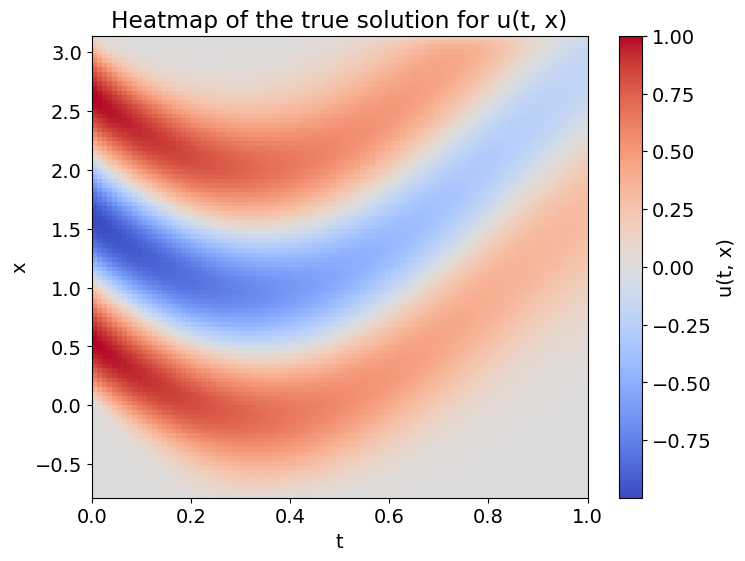

In [6]:

plt.figure(figsize=(8, 6))
plt.imshow(u_true.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Heatmap of the true solution for u(t, x)')

## USER INPUT: Main code to run

In [19]:
# runs the algorithm to fit parameter estimates 

data = u_true

# switch detection parameters
switch_gap = 1
ls_model = "ar"
# sigma = str(len(data)//6)
sigma = str(n_x//6)


# Sets initial parameter value guesses for first time domain 
params_init = [.5, .5]

# set bounds for paramsin the form of : (lower, upper)
#         [alpha,    beta,     bm,     bp]
# model_param_bounds = [(-10, 10), (-10, 10),]
model_param_bounds = None

num_static_params = 1

result = cont_pw_tv_model_ID(data, t, switch_gap, 
                             ls_model, 
                             sigma, params_init,
                             model_param_bounds,
                             num_static_params)

# note that for troubleshooting, all of the results which are dictionaries have keys 
# which can be analyzed as below

print(result.keys())


expected switch number not equal to detected number of switches
times_of_switches =  [0.05050505 0.1010101  0.15151515 0.2020202  0.25252525 0.3030303
 0.35353535 0.4040404  0.45454545 0.50505051 0.55555556 0.60606061
 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586 0.90909091
 0.95959596]
bounds= [(-inf, inf), (0.011054374340285155, 0.011054374340285155)]
dict_keys(['params_dict', 'param_matrix', 'traj_dict', 'traj', 'data_intervals_dict', 'time_intervals_dict', 't_switch_index', 'num_switches', 'num_time_intervals', 'time_of_switch', 'err_dict', 'err_array', 'total_err', 'param_time'])


## Plotting Results

total_error =  0.0017241501288701338
total_error2 =  0.0017241501288701338
parameters:  [[-0.80776414 -0.70016743 -0.58680048 -0.46038623 -0.32370907 -0.17999995
  -0.03227343  0.11638605  0.26257002  0.40298345  0.53458273  0.65528149
   0.76234066  0.85428311  0.92794835  0.9763394   0.99340627  0.98011558
   0.95120983  0.91999826]
 [ 0.01105437  0.01105437  0.01105437  0.01105437  0.01105437  0.01105437
   0.01105437  0.01105437  0.01105437  0.01105437  0.01105437  0.01105437
   0.01105437  0.01105437  0.01105437  0.01105437  0.01105437  0.01105437
   0.01105437  0.01105437]]
param_error =  0.1592687690601262


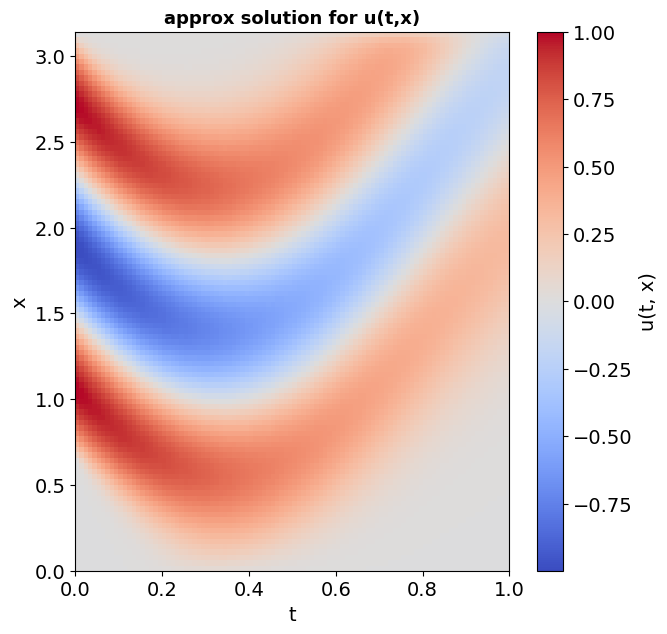

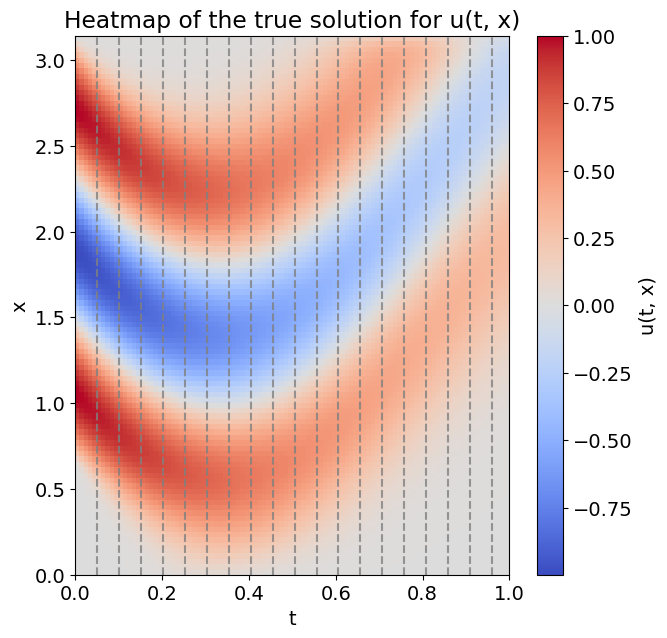

In [20]:
 # result = {'params_dict': params_dict, 
 #               'param_matrix':param_matrix, 
 #               'traj_dict':traj_dict, 
 #               'traj':traj,
 #               'data_intervals_dict':data_intervals_dict, 
 #               'time_intervals_dict':time_intervals_dict, 
 #               't_switch_index':t_switch_index, 
 #               'num_switches':num_switches, 
 #               'num_time_intervals':num_time_intervals,
 #               'time_of_switch':time_of_switch,
 #               'err_dict':err_dict,
 #               'err_array':err_array,
 #               'total_err':total_err,
 #               'param_time':param_time}

# results needed for plotting
num_switches = result['num_switches']
time_intervals_dict = result['time_intervals_dict']
traj_dict = result['traj_dict']
traj = result['traj']
param_matrix = result['param_matrix']
num_time_intervals = result['num_time_intervals']
params_dict = result['params_dict']
err_array = result['err_array']
param_time = result['param_time']
switch_times = result['time_of_switch']

print('total_error = ', result['total_err'])
# print('total_error2 = ', LA.norm(err_array,2)/n_t)


print('parameters: ', param_matrix)

param_approx = np.array([param_time['p0'] , param_time['p1'] ])
param_true = np.stack((param1(t), param2(t)))

print('param_error = ', LA.norm((param_true - param_approx),2)/2)

num_model_params = np.shape(param_matrix)[0]

# plot of approx solution
fig1 = plt.figure(figsize=(7,7))
plt.imshow(traj.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')

plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('approx solution for u(t,x)', fontsize=13, weight= 'bold')

# plot of u true solution
fig2 = plt.figure(figsize=(7,7))
plt.imshow(u_true.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')
for each in switch_times:
    plt.axvline(x=each, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Heatmap of the true solution for u(t, x)')


plt.show()

## Computing contuously varying Parameter

In [51]:
''' 
'''
def sdff_objective(params, data):
    
    # params1 is the array of inner param terms | ex: sin(c1*t + c2) 
    # params2 is the array of weights for the dictionary functions | ex: c1*sin(t)
    params1 = params[0:5]
    params2 = params[5:]

    
    fxn_dictionary, num_dict_fxns = make_dict_fxns(t, params1)

    
    # distance between the predicted data and the real data
    # err = LA.norm(data - (fxn_dictionary @ params2))**2
    err = LA.norm(data - (fxn_dictionary @ params2),2)
    
    # regularization term for sparseness
    gamma = 10e-2 # hyperparameter
    
    # sparse_reg = gamma*LA.norm(params,0)**2
    sparse_reg = gamma*LA.norm(params2,1)
    
    # resulting objective function
    obj =  err**2 + sparse_reg
    
    return obj

'''
def compose (fxn1,fxn2):
    return fxn1(fxn2(t))

t**p # more clever polynomial terms 
'''

############################################################ 
''' 
'''
#     p= 1.*np.sin(-1.+ 3.*ti)
def make_dict_fxns(t, params):
    # each column is it's respective function of time
    fxn_dictionary = np.array([
                      [np.exp(params[0]*t**params[1])],  
                      [np.sin(params[2]*t + params[3])], 
                      # [np.cos(t)],
                      # [np.log(t)],
                      # ''' don't seem to work well'''
                      # [np.tan(t)],
                      # [np.arcsin(t)],
                      # [np.arccos(t)],
                      # [np.arctan(t)],
                      # [1./np.cos(t)],
                      # [1./np.sin(t)],
                      # [1./np.tan(t)],
                      # [t**2], 
                      # [t], 
                      [t**params[4]],
                      # [np.ones(len(t))],
                      # [np.cosh(t)], 
                      # [np.sinh(t)], 
                      # [np.tanh(t)],
                      # [t**.5]
                      ]).T

    num_dict_fxns = len(fxn_dictionary.T)
    return fxn_dictionary, num_dict_fxns

# Sets initial parameter value guesses for first time domain 

num_inner_params = 5
params_init = 1.*np.ones(num_inner_params + 3)

# set bounds for params in the form of : (lower, upper)
# param_bounds = [(-10, 10) for i in range(len(params_init))]
param_bounds = None

# tolerance = 0.01

'''Type of solver used to minimize objective function
   should be one of of the following:

‘Nelder-Mead’ 

‘Powell’ (seems to work best)

‘CG’ 

‘BFGS’

‘L-BFGS-B’

‘COBYLA’ 

'''

approx_param_data1 = param_time[f"p0"]
approx_param_data1 = np.reshape(approx_param_data1,(len(approx_param_data1),1))

approx_param_data2 = param_time[f"p1"]
approx_param_data2 = np.reshape(approx_param_data2,(len(approx_param_data2),1))

def sr_fit(approx_param_data, params_init, param_bounds, num_inner_params):

    # minimizes objective function
    result = minimize(sdff_objective, 
                      params_init, 
                      args=(approx_param_data),
                      method='Powell', 
                      bounds = param_bounds)

    dict_weights = result.x
    print('dict weights = ', dict_weights)

    inner = dict_weights[0:num_inner_params]
    outer = dict_weights[num_inner_params:]


    # puts small weights to zeros
    # threshold = 0.1
    # dict_weights = np.where(np.abs(dict_weights) < threshold, 0, dict_weights)
    # print('dict weights = ', dict_weights)

    # reconstructs data
    fxn_dictionary, num_dict_fxns = make_dict_fxns(t, inner)
    param_sr = fxn_dictionary @ outer
    
    return param_sr, inner, outer

param_sr1, inner1, outer1 = sr_fit(approx_param_data1, params_init, param_bounds, num_inner_params)
param_sr2, inner2, outer2 = sr_fit(approx_param_data2, params_init, param_bounds, num_inner_params)

# computes parameter reconstruction error

true_params = np.stack((param1(t),param2(t)))
sr_params = np.stack((param_sr1 , .011*np.ones((len(t),1)))).reshape((2,100))

param_err = LA.norm((true_params - sr_params),2)/2



print('param_error = ', param_err) 

/var/folders/qn/9q_vv3fs25d1crmhmb6zzsjr0000gn/T/ipykernel_36468/1194309527.py:43: RuntimeWarning: divide by zero encountered in power
  [np.exp(params[0]*t**params[1])],
/var/folders/qn/9q_vv3fs25d1crmhmb6zzsjr0000gn/T/ipykernel_36468/1194309527.py:57: RuntimeWarning: divide by zero encountered in power
  [t**params[4]],
/var/folders/qn/9q_vv3fs25d1crmhmb6zzsjr0000gn/T/ipykernel_36468/1194309527.py:43: RuntimeWarning: overflow encountered in exp
  [np.exp(params[0]*t**params[1])],
/var/folders/qn/9q_vv3fs25d1crmhmb6zzsjr0000gn/T/ipykernel_36468/1194309527.py:25: RuntimeWarning: overflow encountered in scalar power
  obj =  err**2 + sparse_reg


dict weights =  [-2.55503104e+00  6.12147846e-01  3.03028187e+00  1.15515446e+01
  9.64200859e-01  1.33731684e-13  9.78858098e-01  1.03482404e-02]
dict weights =  [-3.18432048e+04 -2.83979973e+00  2.84334641e+01  5.85102919e+00
  3.53308509e+00  2.61230655e+00  2.64666694e+00  3.76931845e-01]
param_error =  0.040384568045786835


## contuously varying Parameter plots

Text(0.5, 1.0, 'true solution for u(t,x)')

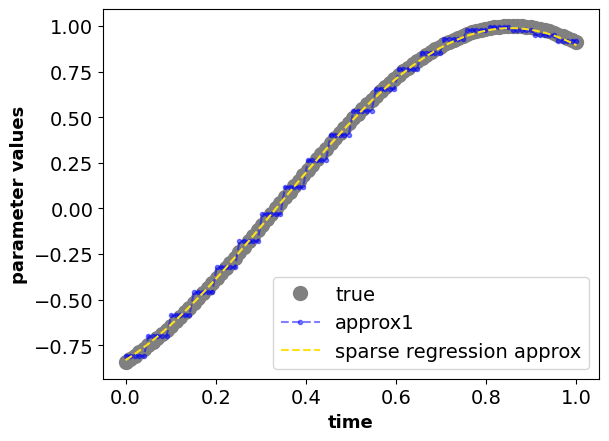

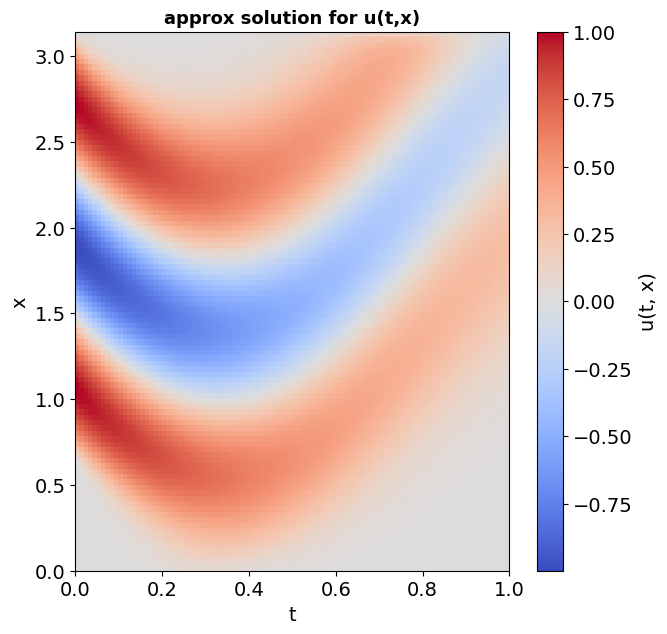

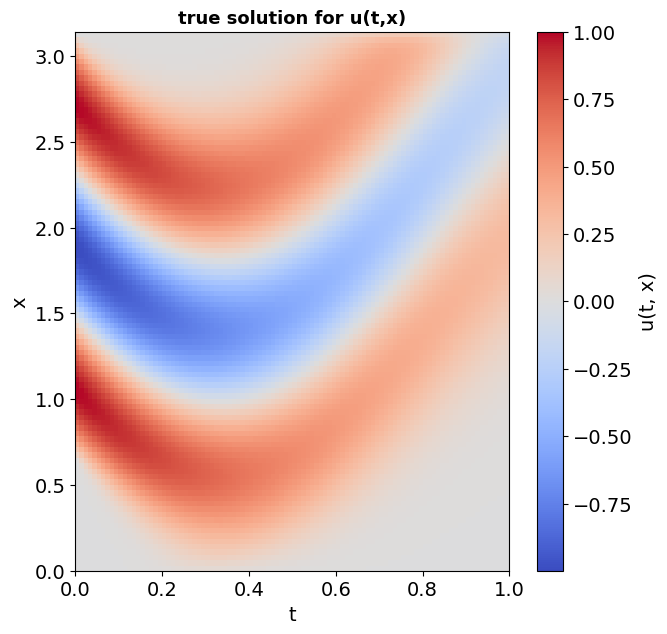

In [49]:
plt.figure()
plt.plot(t, param1(t), 'o',color='gray', alpha=1, markersize = 10, label = 'true')
plt.plot(t, param_time[f"p0"], '--o', alpha=.5, color='blue', markersize=3, label = 'approx1')
plt.plot(t, param_sr1, color='#ffe119', alpha=1, linestyle='--', markersize=5, label='sparse regression approx')  # Purple
plt.xlabel('time', fontsize=13, weight= 'bold')
plt.ylabel('parameter values', fontsize=13, weight= 'bold')
plt.legend(loc='lower right')
# plt.savefig(os.path.join(os.getcwd(), 'params.svg'), format='svg')

# plt.figure()
# plt.plot(t, param2(t), 'o',color='gray', alpha=1, markersize = 10)
# plt.plot(t, param_time[f"p1"], '--o', alpha=.5, color='blue', markersize=3)
# plt.plot(t, param_sr2, color='#ffe119', alpha=1, linestyle='--', markersize=5)  # Purple
# plt.xlabel('time', fontsize=13, weight= 'bold')
# plt.ylabel('parameter values', fontsize=13, weight= 'bold')
# plt.legend(loc='lower right')
# plt.savefig(os.path.join(os.getcwd(), 'params.svg'), format='svg')

#3cb44b
#ffe119'

def pend3(y, ti, inner1, inner2, outer1, outer2, param_matrix):
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))

    # Initialize matrices
    row_xx = np.zeros(n)
    row_xx[0] = -2
    row_xx[1] = 1
    col_xx = row_xx
    
    row_x = np.zeros(n)
    row_x[0] = -1
    col_x = np.zeros(n)
    col_x[0] = -1
    col_x[1] = 1

    # Construct Toeplitz matrix
    T_x = toeplitz(col_x, row_x)
    T_xx = toeplitz(col_xx, row_xx)
    
    # define parameters
    a = outer1[0]*np.exp(inner1[0]*ti**inner1[1]) + outer1[1]*np.sin(inner1[2]*ti + inner1[3]) + outer1[2]*ti**inner1[4]
    d = param_matrix[1,0]
    
    # Compute scaled matrices
    A_x = a * T_x / (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x 
    
    dydt = A @ y + bc
    
    # Return the rates of change as a NumPy array
    return dydt

traj2 = odeint(pend3, data[0,:], t, args = (inner1, inner2, outer1, outer2, param_matrix))


# total_err1 = LA.norm((traj - data),2)/n_t
# print('total_err1 = ', total_err1)

# total_err2 = LA.norm((traj2 - data),2)/n_t
# print('total_err2 = ', total_err2)

# plot of approx solution
fig1 = plt.figure(figsize=(7,7))
plt.imshow(traj2.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')

plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('approx solution for u(t,x)', fontsize=13, weight= 'bold')

# plot of u true solution
fig2 = plt.figure(figsize=(7,7))
plt.imshow(u_true.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')

plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('true solution for u(t,x)', fontsize=13, weight= 'bold')

## Assume constant param: 

no switches detected in signal given chosen parameters
bounds= [(-inf, inf), (0.012626238392402673, 0.012626238392402673)]
dict_keys(['params_dict', 'param_matrix', 'traj_dict', 'traj', 'data_intervals_dict', 'time_intervals_dict', 't_switch_index', 'num_switches', 'num_time_intervals', 'time_of_switch', 'err_dict', 'err_array', 'total_err', 'param_time'])
parameter =  [[-0.26758804]
 [ 0.01262624]]
total_error =  0.274125968905562


Text(0.5, 1.0, 'true solution for u(t,x)')

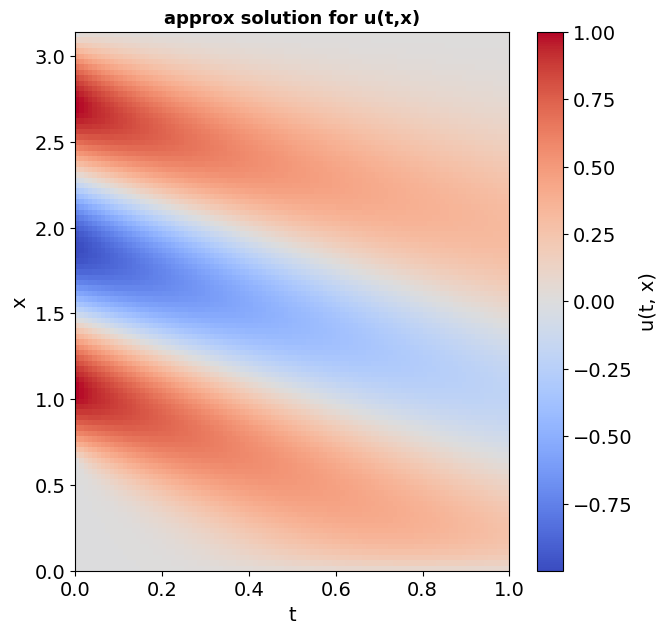

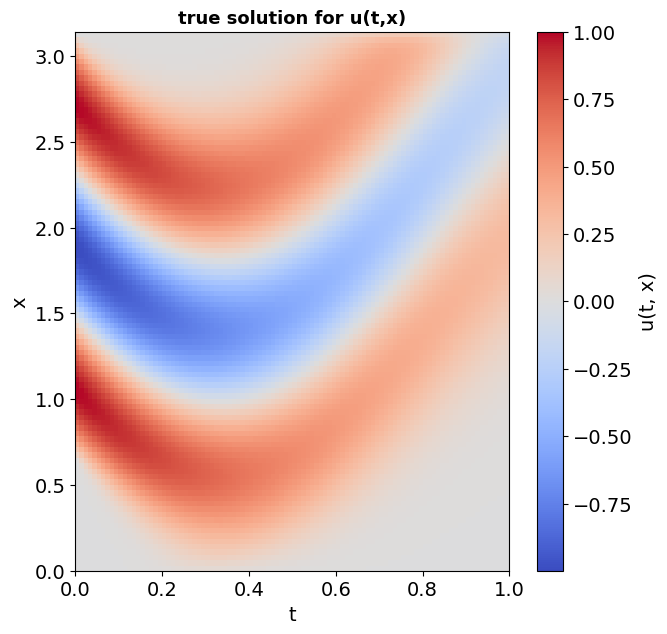

In [50]:
# runs the algorithm to fit parameter estimates 

data = u_true

# switch detection parameters
switch_gap = 1
ls_model = "ar"
sigma = str(0)

# Sets initial parameter value guesses for first time domain 
params_init = [0.1, 0.1]

# set bounds for paramsin the form of : (lower, upper)
#         [alpha,    beta,     bm,     bp]
# model_param_bounds = [(0, 10), (0, 10),]
model_param_bounds = None

num_static_params = 1

result = cont_pw_tv_model_ID(data, t, switch_gap, 
                             ls_model, 
                             sigma, params_init,
                             model_param_bounds,
                             num_static_params)

# note that for troubleshooting, all of the results which are dictionaries have keys 
# which can be analyzed as below

print(result.keys())

# results needed for plotting
num_switches = result['num_switches']
time_intervals_dict = result['time_intervals_dict']
traj = result['traj']
param_matrix = result['param_matrix']
num_time_intervals = result['num_time_intervals']
err_array = result['err_array']

print('parameter = ',param_matrix)
print('total_error = ', result['total_err'])

num_model_params = np.shape(param_matrix)[0]

x = np.linspace(0, np.pi, num = n_x)
t = np.linspace(0, 1,num=n_t)
T, X = np.meshgrid(t, x)


# plot of approx solution
fig1 = plt.figure(figsize=(7,7))
plt.imshow(traj.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')

plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('approx solution for u(t,x)', fontsize=13, weight= 'bold')

# plot of u true solution
fig2 = plt.figure(figsize=(7,7))
plt.imshow(u_true.T, extent=[T.min(), T.max(), X.min(), X.max()],
           origin='lower', aspect='auto', cmap='coolwarm')

plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('true solution for u(t,x)', fontsize=13, weight= 'bold')
